In [ ]:
import os
import json
import time
#import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import scipy.signal as signal
import h5py
import pickle
#from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

import pygama.lgdo.lh5_store as lh5
#from pygama.dsp import build_dsp
#from pygama.dsp.processors.linear_slope_fit import linear_slope_fit
#from pygama.dsp.processors.bl_subtract import bl_subtract

from multihist import Hist1d, Histdd
from datetime import datetime, timezone
from legendmeta import LegendMetadata

import pulser_analysis as pa
import analysis_utility as au

%load_ext autoreload
%autoreload 2

In [ ]:
"""test_file = f'r{run:03}/test_pulser.txt'
test_dict_file = f'r{run:03}/test_pulser.json'
with open(test_file,'r') as datafile:
    test_file = f'r{run:03}/test_pulser.txt'
    n_test = int(len(datafile.read().split())/6)
test_dict = {}
test_dict['test1'] = {}
test_dict['test2'] = {}
for i in range(n_test):
    with open(test_file,'r') as datafile:
        temp = datafile.read().split()[i*6:(i+1)*6]
    ene, att, rate, ttime, key, key2 = temp
    if key2 == '0': key_list = [key]
    else: key_list = [key,key2]
    if i < 7: test_dict['test1'][i] = {'energy':float(ene),'attenuation':int(att),'rate':float(rate),'time':int(ttime),'key_list':key_list}
    else: test_dict['test2'][i-7] = {'energy':float(ene),'attenuation':int(att),'rate':float(rate),'time':int(ttime),'key_list':key_list}
with open(test_dict_file,'w') as f:
    json.dump(test_dict, f, indent=4)"""

In [ ]:
run = 17
meta_path = '/data1/users/dandrea/software/legend-metadata'
lmeta = LegendMetadata(path=meta_path)
chmap = lmeta.hardware.configuration.channelmaps.on("20230126T034922Z")
dsp_config = 'r017/pulser_test/l200-p02-r017-cal-20230215T213215Z-par_dsp.json'
hit_config = 'r017/pulser_test/l200-p02-r017-cal-20230215T213215Z-par_hit.json'
det_names = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
ge_numbers = [chmap[ch]['daq']['fcid'] for ch in chmap.keys() if chmap[ch]['system']=='geds']
ge_off = (26,33,46,47,48,50,84,85,94,105,112,116,117,120,122)
ge_chns = [f'ch{n:03}' for n in ge_numbers if n not in ge_off ]
det_names = [ch for n, ch in zip(ge_numbers,det_names) if n not in ge_off ]
raw_dir = f'/data1/users/dandrea/test_data/raw/r{run:03}_pulser_test'
daq_dir = f'/data1/shared/l200/l200-daq/tier/daq/tst/r{run:03}'
test_dict_file = f'r{run:03}/pulser_test/test_pulser.json'
with open(test_dict_file,'r') as file:
    test_dict = json.load(file)

In [ ]:
"""with open(dsp_config,'r') as file:
    dsp_dict = json.load(file)
for chn in ge_chns:
    dsp_dict[chn]['cusp']['sigma'] = '100*us'
    dsp_dict[chn]['cusp']['flat'] = '0.5*us'
with open('r017/l200-p02-r017-cal-20230215T213215Z-par_dsp_100.json','w') as f:
    json.dump(dsp_dict, f, indent=4)"""

In [ ]:
n_test, n_acq = 2, 9
this_dict = test_dict[f'test{n_test}'][f'{n_acq}']
key_list = [f'l200-p02-r{run:03}-tst-{key}' for key in this_dict['key_list']]
raw_list = [f'{raw_dir}/l200-p02-r{run:03}-tst-{key}_raw.lh5' for key in this_dict['key_list']]

In [ ]:
au.daq_convertion(daq_dir, key_list[1], stream_type = 'ORCA', raw_dir = raw_dir)

In [ ]:
pa.plot_pulser_waveforms('ch003', 'pulser', raw_list[0], nwf = 100, apply_mask = 1, xlim=(3060,3075))#xlim=(3046,3061))

In [ ]:
pa.plot_pulser_fft(ge_chns[:9], det_names[:9], raw_list[0], nwf = 100, apply_mask = 1,ylim=(3e4,3e7))

In [ ]:
pa.pulser_waveform(raw_list[:], chmap, dsp_config, hit_config, test_dict_file, n_test=n_test, n_acq=n_acq,
                   wcut=2100, sconv=200, nstring=3, plot_dir='r017/pulser_test',
                   lh5_file = f'r017/dsp/l200_r{run:03}_pulser_test{n_test}_acq{n_acq}.lh5')

In [ ]:
pa.pulser_dsp_analysis(run, chmap, test_dict_file, n_test=2,n_acq=i, nstring=None,
                       plot_dir='r017/pulser_test/plots')

In [75]:
def plot_pulser_info(chmap, test_dict, n_test, nstring = None, plot_dir = None):
    with open(test_dict_file,'r') as file:
        test_dict = json.load(file)
    acquistions = [k for k in test_dict[f'test{n_test}'].keys()][:]
    print(acquistions)
    fig0, axis0 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    fig1, axis1 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    ge_off = (26,33,46,47,48,50,84,85,94,105,112,116,117,120,122)
    strings = np.array([int(chmap[ch]['location']['string']) for ch in chmap.keys() if chmap[ch]['system']=='geds'])
    if nstring is None: nstring = strings.max()
    for string in range(1,nstring+1):
        ax0 = axis0.flat[string-1]
        ax1 = axis1.flat[string-1]
        #if n_test == 2: axin = ax1.inset_axes([0.24, 0.53, 0.35, 0.45])
        det_names = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]
        ge_numbers = [chmap[ch]['daq']['fcid'] for ch in det_names]
        cc4s = [chmap[ch]['electronics']['cc4']['id'] for ch in det_names]
        chns = [f'ch{n:03}' for n in ge_numbers if n not in ge_off ]
        det_names = [ch for n, ch in zip(ge_numbers,det_names) if n not in ge_off ]
        rate = [float(test_dict[f'test{n_test}'][f'{n_acq}']['rate']) for n_acq in acquistions]
        energy = [float(test_dict[f'test{n_test}'][f'{n_acq}']['energy'])*1000 for n_acq in acquistions]
        for i, chn in enumerate(chns[:]):
            if det_names[i] == 'B00089D': continue
            #try:
            fwhm = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['fwhm'] for n_acq in acquistions]
            fwhm_err = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['fwhm_err'] for n_acq in acquistions]
            pos = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['position'] for n_acq in acquistions]
            if n_test == 1:
                ax0.errorbar(rate, fwhm,yerr=fwhm_err,marker='o', label=f'{det_names[i]}-{cc4s[i]}')
                ax1.plot(rate, pos,'o-',label=f'{det_names[i]}-{cc4s[i]}')
            if n_test == 2:
                ax0.errorbar(energy, fwhm,yerr=fwhm_err,marker='o', label=f'{det_names[i]}-{cc4s[i]}')
                ax1.plot(energy, pos,'o-',label=f'{det_names[i]}-{cc4s[i]}')
                #axin.plot(energy, pos,'o-',label=f'{det_names[i]}')
            #except: pass
        ax0.legend(title=f'String {string}',loc='upper left')
        if n_test == 1:
            ax0.set_xscale('log')
            ax1.set_xscale('log')
            x_name = 'rate (Hz)'
            fstring = 'rate'
            xlims = (0.005,120)
        if n_test == 2:
            x_name = 'expected position (keV)'
            fstring = 'position'
            xlims = (-2000,6100)
        ax0.set_xlabel(x_name)
        ax0.set_ylabel('FWHM (keV)')
        ax0.set_xlim(xlims[0],xlims[1])
        ax1.legend(title=f'String {string}',loc='upper left')
        ax1.set_xlabel(x_name)
        ax1.set_ylabel('pulser position (keV)')
        ax1.set_xlim(xlims[0],xlims[1])
        """if n_test == 2:
            axin.set_xlim(40,250)
            axin.set_ylim(40,500)
            axin.set_yticklabels('')"""
    if plot_dir is not None:
        fig0.savefig(f'{plot_dir}/test{n_test}_fwhm_vs_{fstring}.png',dpi=300, bbox_inches='tight')
        fig1.savefig(f'{plot_dir}/test{n_test}_position_vs_{fstring}.png',dpi=300, bbox_inches='tight')

['0', '1', '2', '3', '4', '5', '6']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


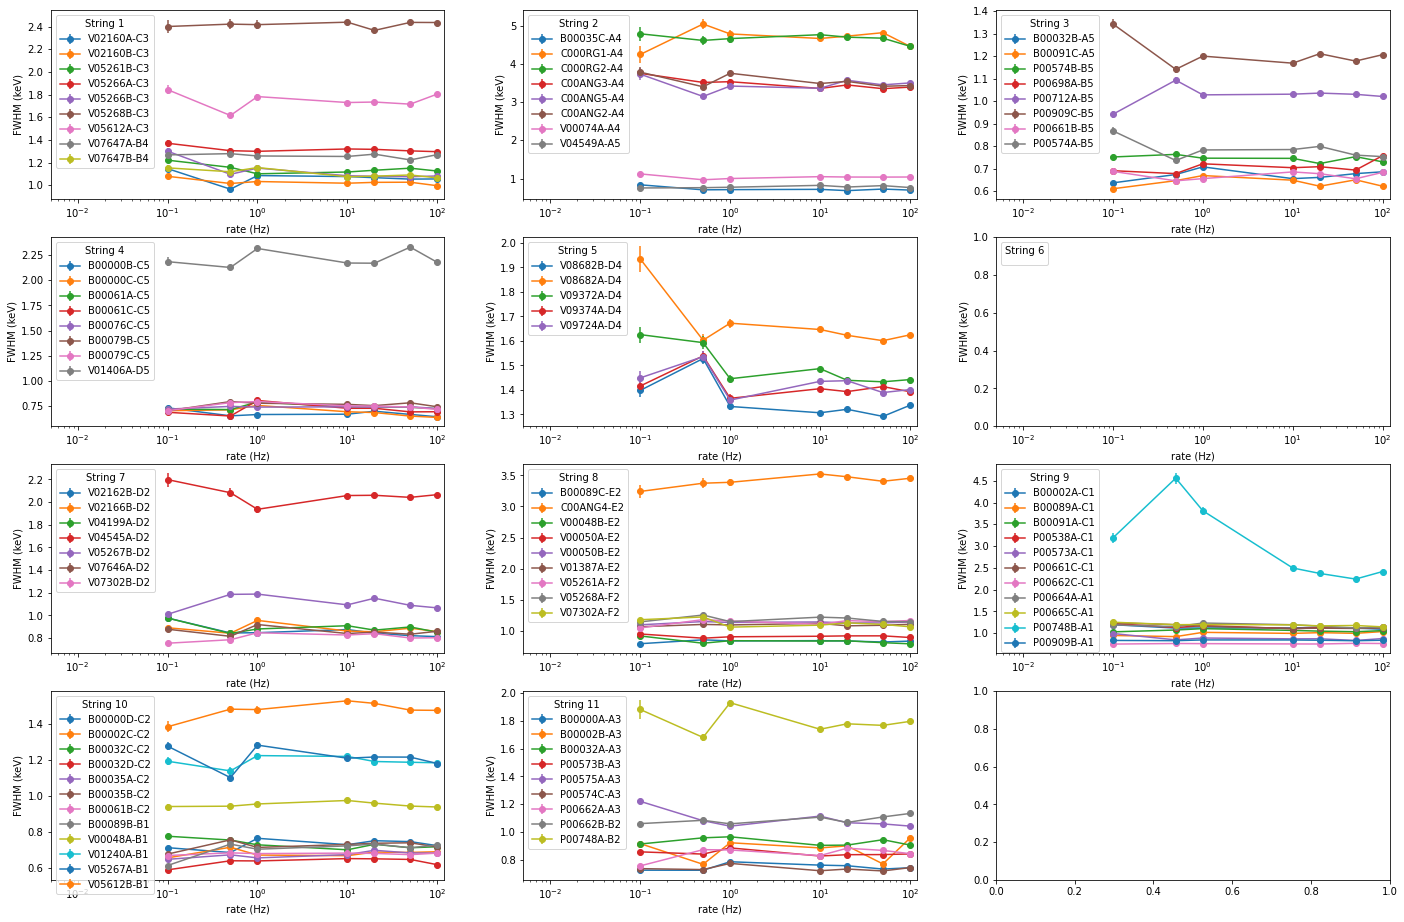

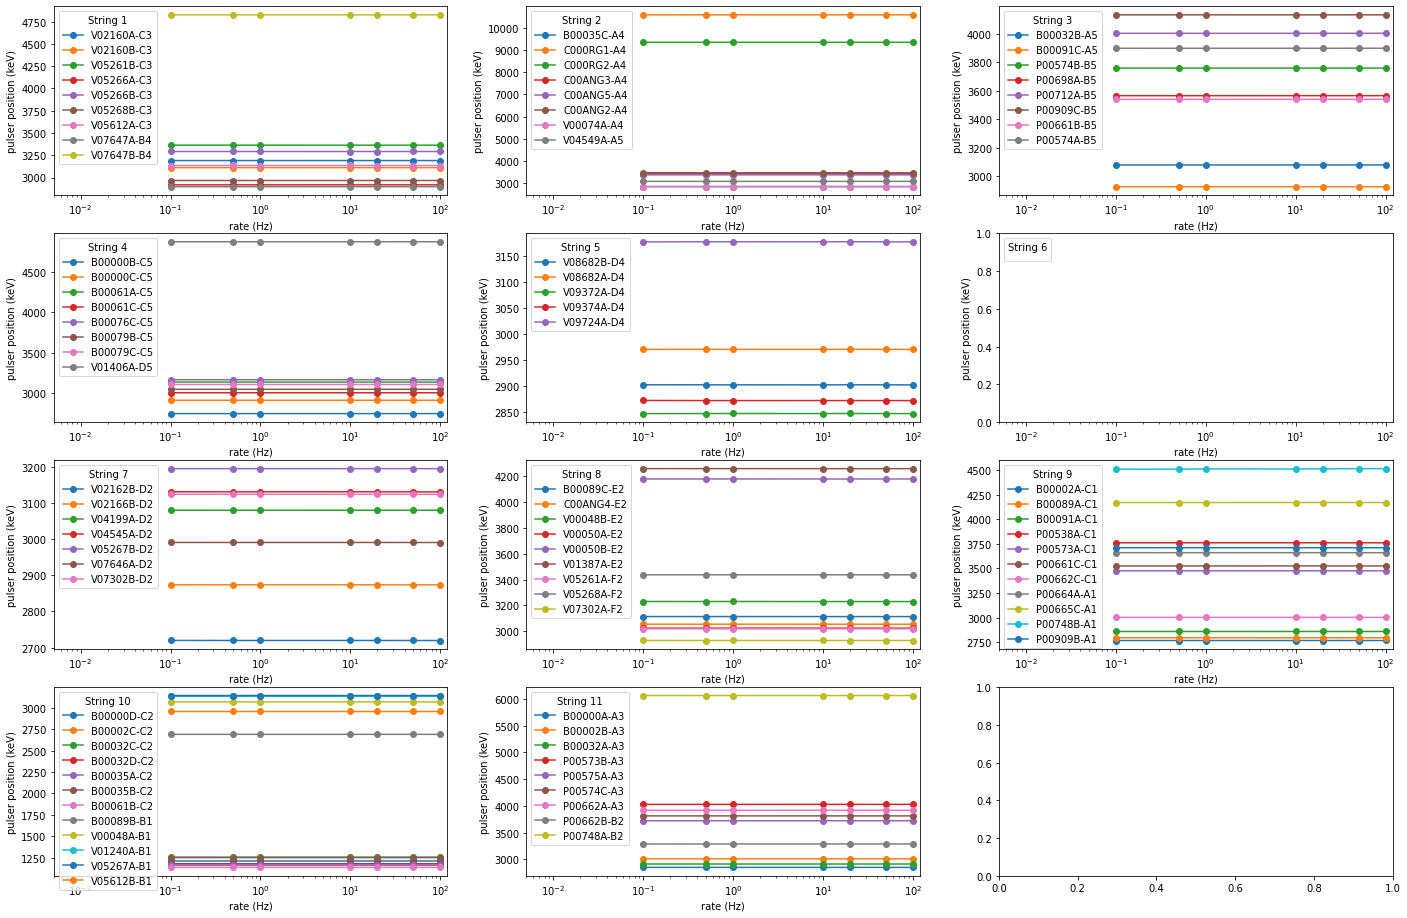

In [73]:
plot_pulser_info(chmap, test_dict, n_test=1, nstring = None, plot_dir = 'r017/pulser_test/plots')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


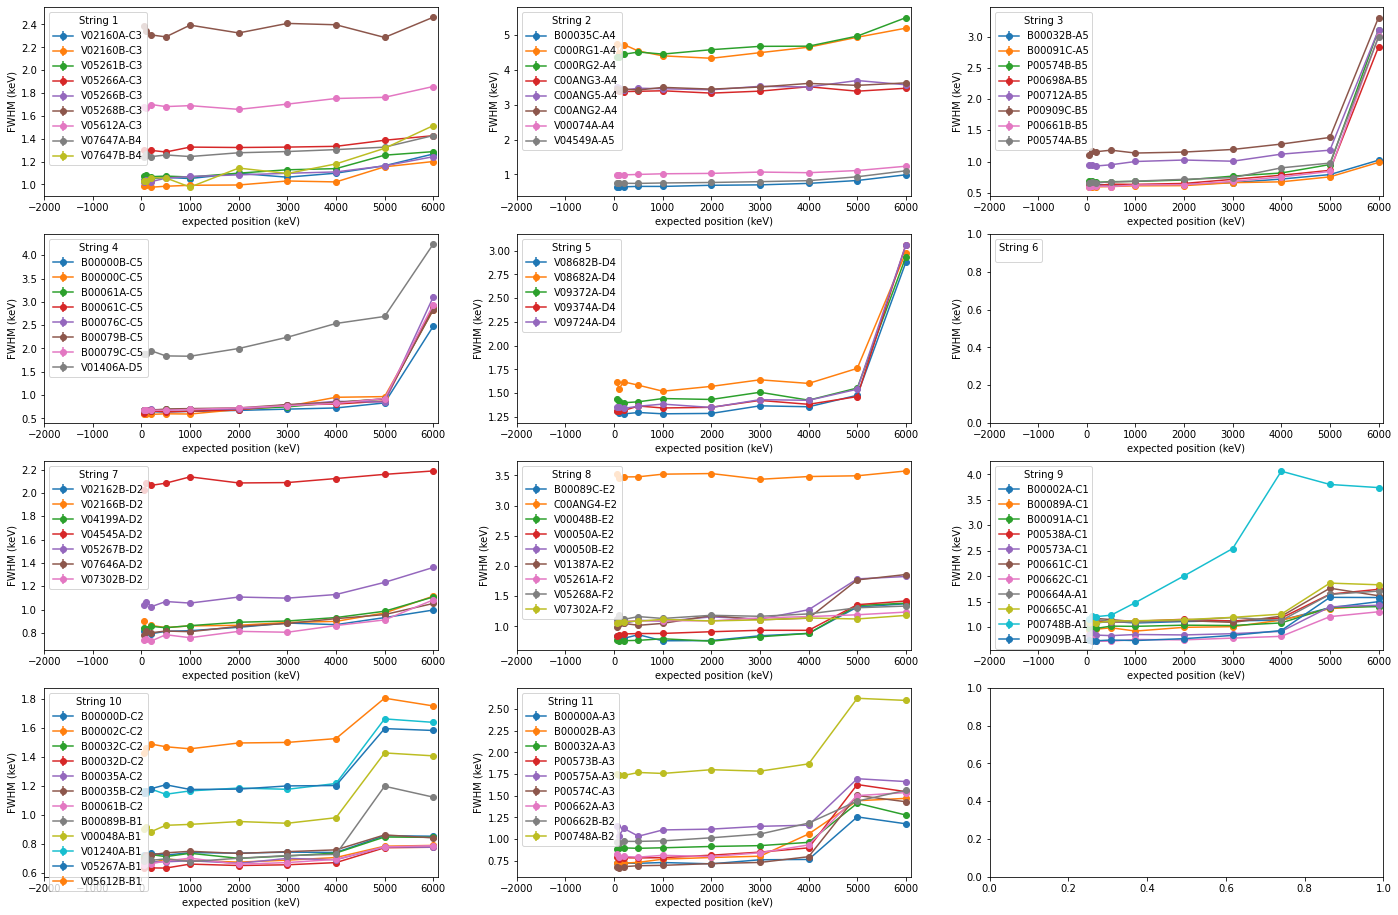

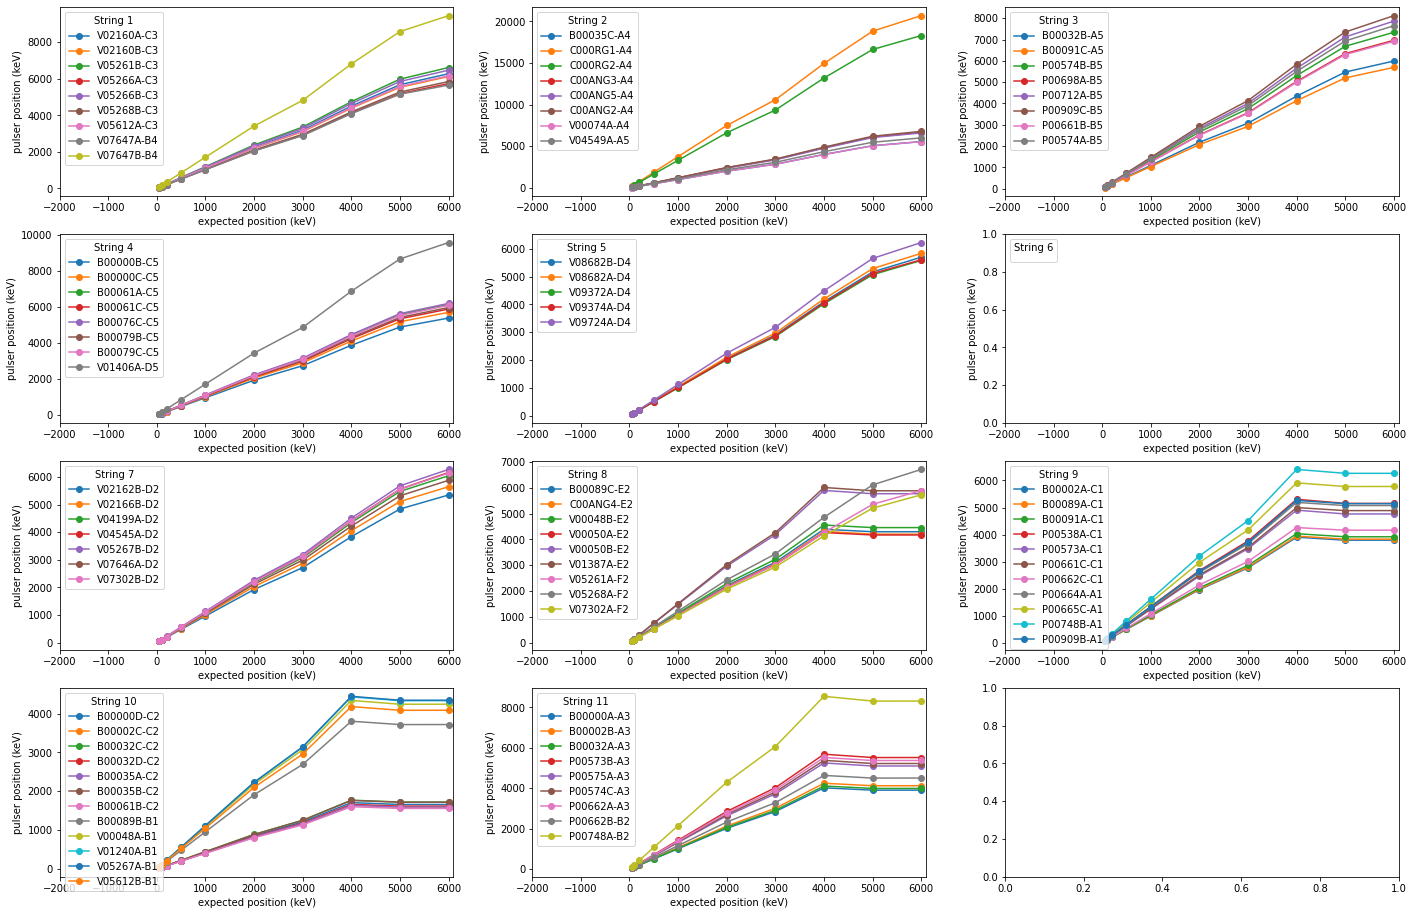

In [76]:
plot_pulser_info(chmap, test_dict, n_test=2, nstring = None, plot_dir = 'r017/pulser_test/plots')